In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn.metrics import r2_score
from datetime import datetime
import matplotlib.pyplot as plt

# Pre-processing

In [2]:
df_raw = pd.read_csv('dataset_covid_indonesia.csv')
df_raw.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,3,0,0,3,3,0,0,...,106.836118,-6.204699,0.28,0.28,0.0,0.0,0.00%,0.00%,NaN,NaN
1,3/1/2020,ID-JB,Jawa Barat,3,0,0,3,3,0,0,...,107.603708,-6.920432,0.07,0.07,0.0,0.0,0.00%,0.00%,NaN,NaN
2,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,5,0,0,...,106.836118,-6.204699,0.18,0.46,0.0,0.0,0.00%,0.00%,0.67,1.0
3,3/2/2020,ID-JB,Jawa Barat,0,0,0,0,3,0,0,...,107.603708,-6.920432,0.00,0.07,0.0,0.0,0.00%,0.00%,0.00,1.0
4,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,...,113.921327,-0.789275,0.01,0.01,0.0,0.0,0.00%,0.00%,NaN,NaN


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872 entries, 0 to 2871
Data columns (total 37 columns):
Date                           2872 non-null object
Location ISO Code              2872 non-null object
Location                       2872 non-null object
New Cases                      2872 non-null int64
New Deaths                     2872 non-null int64
New Recovered                  2872 non-null int64
New Active Cases               2872 non-null int64
Total Cases                    2872 non-null int64
Total Deaths                   2872 non-null int64
Total Recovered                2872 non-null int64
Total Active Cases             2872 non-null int64
Location Level                 2872 non-null object
City or Regency                0 non-null float64
Province                       2768 non-null object
Country                        2872 non-null object
Continent                      2872 non-null object
Island                         2768 non-null object
Time Zone          

In [4]:
# Terlihat banyak sekali columns yang tidak berguna. Selanjutnya akan disortir columns yang berguna saja.
df_with_valuable_columns = df_raw.loc[:, ['Date', 'Location ISO Code', 'Total Cases']]
df_with_valuable_columns.head()

,Date,Location ISO Code,Total Cases
0,3/1/2020,ID-JK,3
1,3/1/2020,ID-JB,3
2,3/2/2020,ID-JK,5
3,3/2/2020,ID-JB,3
4,3/2/2020,IDN,2


In [5]:
# Fokus pada Indonesia secara keseluruhan saja (Location ISO Code = IDN)
df_idn = df_with_valuable_columns[df_with_valuable_columns['Location ISO Code'] == 'IDN'].reset_index()
df_idn.head()

,index,Date,Location ISO Code,Total Cases
0,4,3/2/2020,IDN,2
1,7,3/3/2020,IDN,2
2,10,3/4/2020,IDN,2
3,13,3/5/2020,IDN,2
4,17,3/6/2020,IDN,4


In [6]:
# Selanjutnya, drop column Location ISO Code dan index karena sudah tidak diperlukan lagi.

In [7]:
data = df_idn.loc[:, ['Date', 'Total Cases']]
data.head()

,Date,Total Cases
0,3/2/2020,2
1,3/3/2020,2
2,3/4/2020,2
3,3/5/2020,2
4,3/6/2020,4


Data siap digunakan.

# Model Pertumbuhan Logistik (Logistic Growth Model)

Pada dasarnya, Model Pertumbuhan Logistik seringkali digunakan untuk memodelkan pertumbuhan populasi dengan sumber daya dan ruang yang terbatas. Sehingga, jumlah kumulatif kasus Corona di Indonesia per hari bisa diasumsikan sama dengan pertumbuhan populasi orang yang terinfeksi Corona.

In [8]:
# Referensi ->> https://www.wolframcloud.com/obj/covid-19/Published/Logistic-Growth-Model-for-COVID-19.nb
def logistic_model(x, k, t, L):
    return L/(1+np.exp(-k*(x-t)))

# Dengan menggunakan fungsi curve_fit function dari scipy library dan dataset yang kita punyai,
# kita bisa mendapatkan estimasi parameter values dan errors yang optimal dari model.
index_days = list(data.index)
total_cases_per_days = list(data.iloc[:, 1])
fit = curve_fit(logistic_model, index_days, total_cases_per_days)
A, B = fit
infection_speed_rate, day_peak, max_infected_people = A
errors = [np.sqrt(B[i][i]) for i in [0,1,2]]

# Dari curve_fit, kita belum bisa mendapatkan prediksi hari dimana pandemik akan berakhir.
# Tapi bisa kita lihat bahwa kita bisa mendapatkan total kasus saat pandemik berakhir.
# Dengan bantuan fungsi fsolve dari scipy library dan memanfaatkan data max_infected_people dan fungsi model,
# kita bisa mendapatkan hari dimana pandemik berakhir.
day_end = int(fsolve(lambda x: logistic_model(x, infection_speed_rate, day_peak, max_infected_people) - int(max_infected_people), day_peak))
print(f'''infection_speed_rate: {infection_speed_rate},
std_err: {errors[0]}

day_peak: {day_peak},
std_err: {errors[1]}

max_infected_people: {max_infected_people},
std_err: {errors[2]}

day_end: {day_end}''')

infection_speed_rate: 0.05072594814362884,
std_err: 0.0013111788846679785

day_peak: 89.8232012535864,
std_err: 1.7154877248746225

max_infected_people: 53728.796289306054,
std_err: 2236.3587125387826

day_end: 309


# Evaluasi Metode

In [12]:
cases_with_model = [logistic_model(case, infection_speed_rate, day_peak, max_infected_people) for case in index_days]
print(f'R-squared: {r2_score(data.iloc[:, 1], cases_with_model)}')

R-squared: 0.9955316036547331


Dengan hasil perhitungan R-squared yang hampir mendekati 1, ini menunjukkan bahwa terdapat korelasi yang sangat kuat antara
data riil dengan data hasil dari model logistik. Ini menunjukkan bahwa model yang digunakan cukup baik dalam kasus ini.

# Plotting

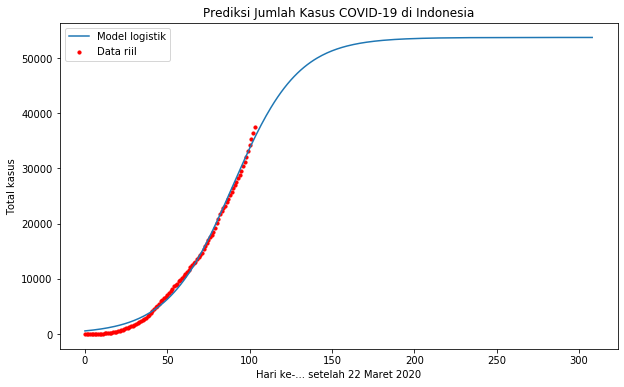

In [10]:
day_0 = pd.to_datetime('22/3/2020', format='%d/%m/%Y')
x_index = index_days + list(range(max(index_days), day_end))
plt.rcParams['figure.figsize'] = [10, 6]
# Data riil
plt.scatter(index_days, total_cases_per_days, label="Data riil", color="red", s=10)
# Model logistik
plt.plot(x_index, [int(logistic_model(i, infection_speed_rate, day_peak, max_infected_people)) for i in x_index], label="Model logistik" )
plt.legend()
plt.title('Prediksi Jumlah Kasus COVID-19 di Indonesia')
plt.ylabel('Total kasus')
plt.xlabel('Hari ke-... setelah 22 Maret 2020')
plt.show()

# Kesimpulan

In [11]:
day_peak_start_fmt = (day_0 + pd.Timedelta(days=int(day_peak - errors[1]))).strftime('%d %b %Y')
day_peak_end_fmt = (day_0 + pd.Timedelta(days=int(day_peak + errors[1]))).strftime('%d %b %Y')
day_end_fmt = (day_0 + pd.Timedelta(days=day_end)).strftime('%d %b %Y')

print(f'''Laju pertumbuhan tingkat penyebaran virus adalah {infection_speed_rate},
dengan standard error sebesar {errors[0]}.
    
Puncak pandemik diperkirakan terjadi sekitar {int(day_peak - errors[1])}-{int(day_peak + errors[1])} hari setelah 22 Mar 2020,
yaitu sekitar {day_peak_start_fmt} - {day_peak_end_fmt}.
Perlu dipahami bahwa puncak pandemik disini bukanlah pandemik sudah berakhir.
Puncak pandemik adalah hari dimana penambahan kasus per hari itu mencapai nilai maksimal.
Dengan kata lain, pertumbuhan kasus perhari setelah puncak pandemik akan mengalami penurunan.

Pandemik diperkirakan berakhir saat {day_end} hari setelah 22 Mar 2020, yaitu sekitar {day_end_fmt},
dengan total orang yang terinfeksi diperkirakan mencapai sekitar {int(max_infected_people - errors[2])}-{int(max_infected_people + errors[2])} orang.''')

Laju pertumbuhan tingkat penyebaran virus adalah 0.05072594814362884,
dengan standard error sebesar 0.0013111788846679785.
    
Puncak pandemik diperkirakan terjadi sekitar 88-91 hari setelah 22 Mar 2020,
yaitu sekitar 18 Jun 2020 - 21 Jun 2020.
Perlu dipahami bahwa puncak pandemik disini bukanlah pandemik sudah berakhir.
Puncak pandemik adalah hari dimana penambahan kasus per hari itu mencapai nilai maksimal.
Dengan kata lain, pertumbuhan kasus perhari setelah puncak pandemik akan mengalami penurunan.

Pandemik diperkirakan berakhir saat 309 hari setelah 22 Mar 2020, yaitu sekitar 25 Jan 2021,
dengan total orang yang terinfeksi diperkirakan mencapai sekitar 51492-55965 orang.


# Referensi

Dataset: https://www.kaggle.com/hendratno/covid19-indonesia

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

https://www.wolframcloud.com/obj/covid-19/Published/Logistic-Growth-Model-for-COVID-19.nb

https://en.wikipedia.org/wiki/Logistic_function

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/